# 02 - Relating rawnav data to other data sources with `wmatarawnav`

This notebook introduces how the `wmatarawnav` package and methods developed for the WMATA Analysis of Fine-Grained Bus AVL to Evaluate Queue Jump Effectiveness study (Queue Jump Effectiveness study) can be used to relate WMATA ranwav data to other data sources such as intersections, stops, or evaluation segments. These associated datasets can then be used with the rawnav data for further analysis. 

As before, code for this project exists in two general forms:
1. **Code usable for any analysis of rawnav data.** Functions for relating rawnav data to other sources are contained in the in-development Python package `wmatarawnav`.
2. **Code specific to the Queue Jump Effectiveness study**. This code contains project-specific steps to relate rawnav data to other data using functions in the `wmatarawnav` package along the way. 

In this notebook, code usable for any analysis of rawnav data are illustrated using the custom functions contained in the `wmatarawnav` package. The actual process used for the Queue Jump Effectiveness study will differ slightly in form, but still makes use of these general steps.

The contents of this notebook include:

1. Environment Setup
2. Rawnav Data Management
3. Associating Rawnav to Other Data Sources
4. Reloading Stored Rawnav Data
5. Filtering Stored Rawnav Data
6. Relating Rawnav Observations to WMATA Stops and Schedule


## 1. Environment Setup

We begin by importing dependencies required for this notebook and the wmatarawnav package using `import wmatarawnav as wr`. These import steps will differ according to the context and as the development of the package continues. Further instructions will be provided for importing these functions for use in future projects and in other situations, as well as for installing the required dependencies of `wmatarawnav`.  

In [2]:
import os, sys, glob, pandas as pd
sys.path.append('../..')
path_demo_data = os.path.join("../../data/00-raw/demo_data")
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import wmatarawnav as wr

## 2. Rawnav Data Management and Processing Approach

The `wmatarawnav` approach to processing rawnav data is based on several key design considerations, but is agnostic towards how data is stored and otherwise managed. This section will briefly discuss these design choices for those who may use the `wmatarawnav` codebase for later analyses.

### Data Management

The rawanv parsing functions discussed in *Introduction to parsing rawnav data with `wmatarawnav`* ultimately produce two tables: a table of rawnav 'pings' for individual bus runs and a summary table that provides an aggregate summary of those runs. These tables could be uploaded to a database for further analysis, visualized using Tableau, or used in myriad other ways. 

For the Queue Jump Effectiveness study, these tables are stored as a [Parquet-format file](https://databricks.com/glossary/what-is-parquet#:~:text=Parquet%20is%20an%20open%20source,like%20CSV%20or%20TSV%20files.&text=Parquet%20can%20only%20read%20the%20needed%20columns%20therefore%20greatly%20minimizing%20the%20IO.) before being reloaded for later analyses. Part of the larger Apache Arrow project, Parquet allows for fast retrieval and compact storage of large datasets. One can consider it analogous to a CSV that is compressed and structured for improved retrieval of chunks of data partitioned on a key field (such as a route identifier). For use in analysis, these Parquet files are loaded and converted to Pandas Dataframes. The Arrow project also defines the Arrow format for an in-memory table, but this is largely not used in the Queue Jump Effectiveness study except as an intermediate step between the Parquet and Dataframe format. While the use of the Parquet format is not required for the rawnav functions, we recommend it as a storage mechanism over alternatives like a database or CSV export for the following reasons:

1. *Many rawnav traveltime decomposition functions require the processing of all runs of a particular route in a study period.* For instance, to calculate the free flow speed over a segment, the 95th percentile speeds of all runs are needed. This requires rawnav runs to be analyzed in bulk, rather than using SQL database `SELECT` `FROM` `WHERE`-style commands to filter to a particular set of runs. Parquet loads data in bulk faster than CSV or a remote database, especially if only select columns or partitions are needed.
2. *The rawnav traveltime decomposition approach described in the next section does not require successive updates to the source rawnav data*. In this way, the utility of a database for read-write operations is less necessary. Moreover, the use of saved flat files in Parquet also helps to improve the reproducibility of an analysis.

There are several downsides to the use of Parquet to briefly address: until the summer of 2020, it was not suited to storing geospatial data (relative to an alternative like PostgreSQL with PostGIS). Collaborative work with this data would require very large datasets to be hosted on a shared drive in a way that may be less practical than a database. The format is also less suited to successive additions of data like a database, though the partitioning of the data can be structured in a way to address this shortcoming. As with other storage formats, the Python-native data types must be converted back and forth to an Arrow/Parquet types; doing so requires some degreee of mindfulness about data types, just as one would be concerned with the schema of database tables.

### Processing Approach

Because rawnav data is large and spatial in nature, thoughtful approaches are needed to make working with the data time efficient and user friendly. The `wmatarawnav` processing code relies on an approach centered around "chunking" and sets of index and summary tables to make this approach user friendly. 

#### Chunking

While rawnav data is large (all October 2019 data is approximately 10 GB compressed), it is not excessively large. Distributed data-processing methods such as Spark are not needed, and once the set of data is reduced to a set of routes, it is also not large enough to require parallel processing methods such as Dask. In particular, parallel processing adds additional processing overhead that could slow analyses of smaller sets of data in the future, and are not always suited to geospatial operations.

Instead, the Queue Jump Effectiveness project relies on an approach that breaks the data into smaller chunks by route and then by day of week to perform operations in memory using standard Python approaches with the libraries like Pandas and Geopandas. This approach is likely to be slower for processing data for the set of routes in the Queue Jump Effectiveness project, but reduces the time needed to write and tune code and will make later ad-hoc analyses using the `wmatarawnav` codebase faster. The decision to iterate by day of week is arbitrary, but helps to make the size of data kept in memory smaller and more readily permits the exclusion of weekends or Mondays and Fridays from an analysis. Chunking by date may be another appropriate approach, but creating chunks that are too small can slow the process of working with the data.

#### Index and Summary Tables

Processing a month's worth of rawnav data for 15 WMATA routes takes approximately 4 hours. Additional modifications to stored rawnav data (say, in order to calculate new columns or relate rawnav data to stop locations) would require additional write time and potentially create copies of the data that would be burdensome to store in memory or on disk. 

The `wmatarawnav` and Queue Jump Effectiveness approach to working with rawnav data is generally as follows:

1. Rawnav data remains relatively untouched after initial conversion from its format in .txt files to a tabular format. A rawnav summary table summarizes basic characteristics of each run, such as the odometer distance and overall travel time.
2. Functions take rawnav data and another geometry (e.g., an evaluation segment geometry or the WMATA schedule database) as input and return two outputs:
    - *Index tables* that identify where in the rawnav data interesting things are happening (e.g., start and ends of evaluation segments, stop locations, start and end of an area around a stop, etc.)
    - *Summary tables* that provide run-level summary statistics (e.g., average speed over an evaluation segment, number of stops served, etc.). These tables add to the rawnav summary table described in item 1 above.
   An illustration of these functions and their outputs is shown below in **Figure 1**. The functions shown are in fact wrapper functions around a set of spatial join, data cleaning, and summarization functions.
   
   **Figure 1. Illustration of Functions Relating Rawnav to Other Data Sources**
   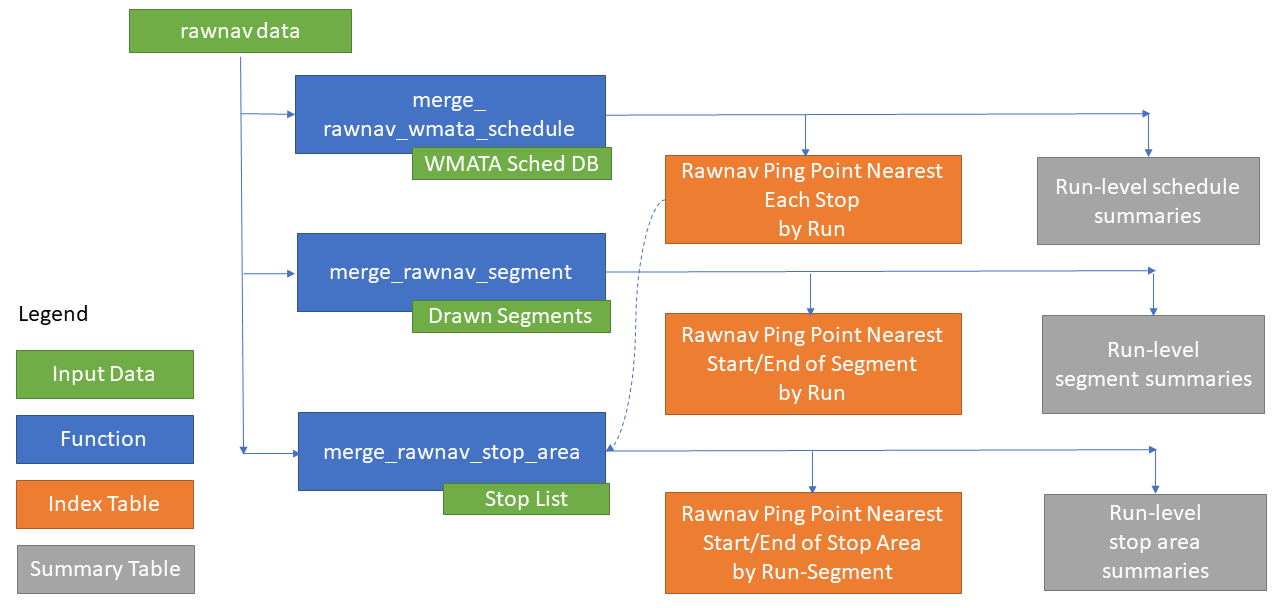

   The index tables returned by these functions record the specific rawnav pings for each run that mark where evaluation segments begin and end, and so forth. An illustration of these index tables is shown below in **Figure 2**.

   **Figure 2. Illustration of Rawnav Index Tables relative to Rawnav Data**
   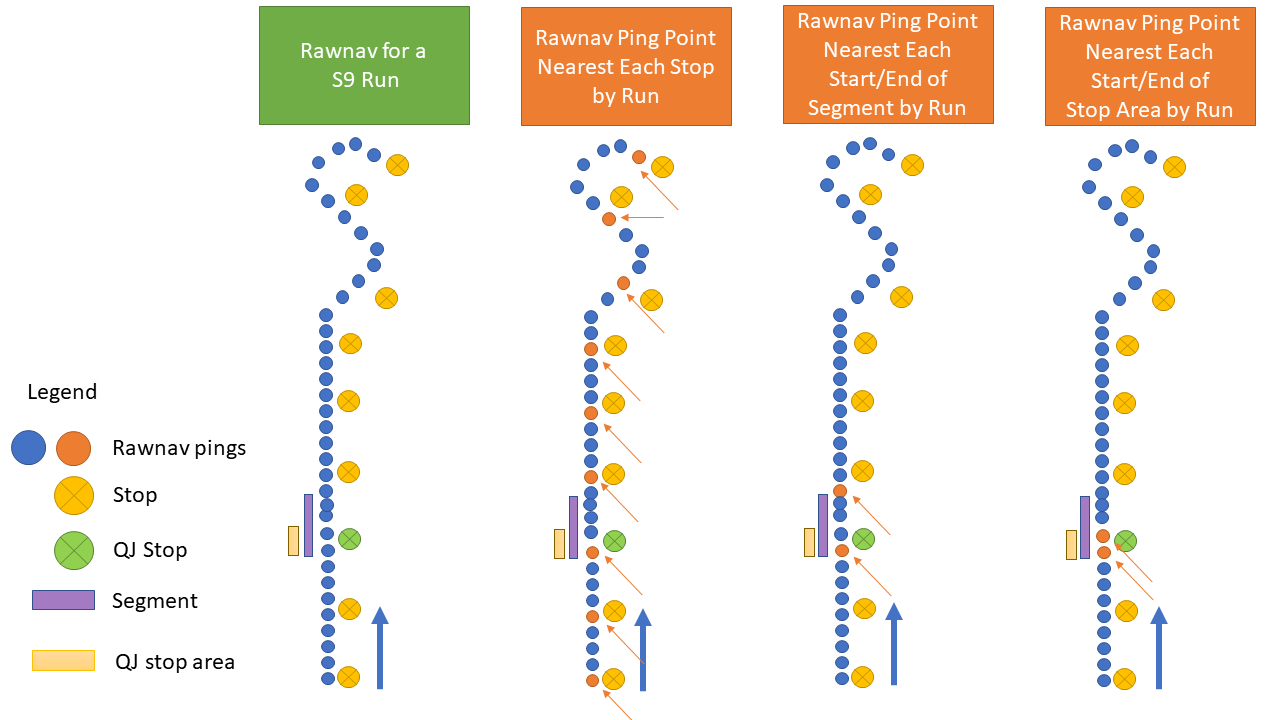
    
3. Index and summary tables are used to filter rawnav data as needed (e.g., keeping only rawnav pings that fall within evaluation segments referenced in an index table or keeping only rawnav runs that have complete data from first stop to last stop) or to calculate certain summary statistics for which individual rawnav pings are not needed (e.g., average total travel time through evaluation segments). 
   A consequence of this approach is that the segment length (or other measured distances) will differ ever so slightly for each bus run. In some cases, nearest point will be slightly before segment starts or slightly after by a number of feet (see illustration in **Figure 3**). By removing cases where rawnav pings don’t closely align to endpoints and being sensitive to the odometer distance and timestamp of each point, comparability across bus runs will be preserved.

   **Figure 3. Illustration of How Rawnav Ping Point Nearest Each Start/End of Segment by Run Can Differ**
   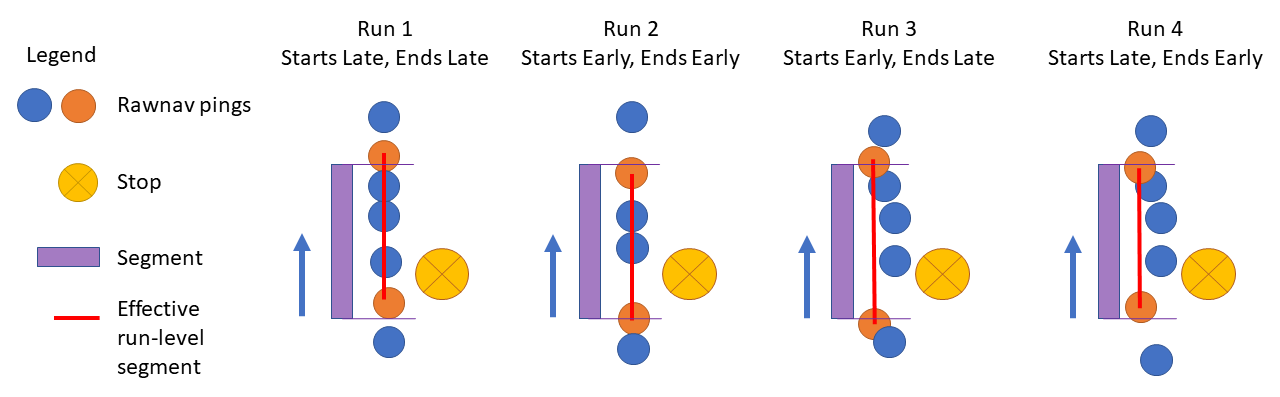

4. As part of travel time decomposition calculations (not shown in this notebook), additional fields and modifications to the data are then performed with this subset of data. Postponing calculations or further data cleaning to this reduced set of data results in faster overall processing time and more manageable datasets. 

## 3. Reload Stored Rawnav Data

In the following notebook, we'll use data previously loaded and processed for route H8 (see the *Introduction to parsing rawnav data with `wmatarawnav`* notebook).

The `wr.read_cleaned_rawnav` function with the given arguments below returns a pandas dataframe. 

In [4]:
analysis_routes = ['H8']
path_processed_route_data = os.path.join("../../data/00-raw/demo_data/02_notebook_data/RouteData")
restrict_n = 5000
analysis_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

rawnav_dat = wr.read_cleaned_rawnav(
    analysis_routes_=analysis_routes,
    path_processed_route_data = os.path.join(path_demo_data,"02_notebook_data","RouteData"),
    restrict=restrict_n,
    analysis_days=analysis_days)
rawnav_dat = wr.fix_rawnav_names(rawnav_dat)

rawnav_dat.head()

,index_loc,lat,long,heading,door_state,veh_state,odomt_ft,sec_past_st,stop_window,row_before_apc,route_pattern,route,pattern,index_trip_start_in_clean_data,index_trip_end_in_clean_data,filename,start_date_time,wday
0,0,38.93007,-77.037932,158.0,C,S,0.0,1.0,,0,H802,H8,02,0,1505,rawnav02807191019.txt,2019-10-18 08:00:00,Friday
1,1,38.93007,-77.037932,158.0,C,S,0.0,1.0,X-1,0,H802,H8,02,0,1505,rawnav02807191019.txt,2019-10-18 08:00:00,Friday
2,2,38.93007,-77.037932,158.0,C,S,0.0,1.0,E01,0,H802,H8,02,0,1505,rawnav02807191019.txt,2019-10-18 08:00:00,Friday
3,3,38.93007,-77.037930,158.0,O,S,0.0,163.0,,1,H802,H8,02,0,1505,rawnav02807191019.txt,2019-10-18 08:00:00,Friday
4,5,38.93007,-77.037930,158.0,C,S,0.0,178.0,,0,H802,H8,02,0,1505,rawnav02807191019.txt,2019-10-18 08:00:00,Friday


Similarly, the `wr.read_summary_rawnav` function with the given arguments below returns our run summary table. 

In [5]:
rawnav_summary_dat, rawnav_trips_less_than_600sec_or_2miles = wr.read_summary_rawnav(
    analysis_routes_=analysis_routes,
    path_processed_route_data=path_processed_route_data,
    restrict=restrict_n,
    analysis_days=analysis_days)
rawnav_summary_dat = wr.fix_rawnav_names(rawnav_summary_dat)

rawnav_summary_dat.head()

Removing 70 out of 1679 trips/ rows with TripDurFromSec < 600 seconds or DistOdomMi < 2 miles from route H8


,fullpath,filename,file_busid,file_id,taglist,route_pattern,tag_busid,route,pattern,wday,...,trip_duration_from_tags,dist_odom_mi,speed_odom_mph,speed_trip_tag_mph,crow_fly_dist_lat_long_mi,lat_start,long_start,lat_end,long_end,count1
0,C:\Downloads\October 2019 Rawnav\Vehicles 0-29...,rawnav02626191001.txt,2626,2626191001,"988, H802,2626,09/30/19,08:10:01,44714,05280",H802,2626.0,H8,2,Monday,...,0 days 00:47:47.000000000,6.089394,7.646257,7.65,2.072787,38.929962,-77.032378,38.920430,-76.995858,1
1,C:\Downloads\October 2019 Rawnav\Vehicles 0-29...,rawnav02626191001.txt,2626,2626191001,"2475, H801,2626,09/30/19,08:57:48,44714,05280",H801,2626.0,H8,1,Monday,...,0 days 00:50:23.000000000,5.881061,7.003579,7.00,2.435970,38.920430,-76.995858,38.931913,-77.038655,1
2,C:\Downloads\October 2019 Rawnav\Vehicles 0-29...,rawnav02673191022.txt,2673,2673191022,"3378, H802,2673,10/21/19,15:19:01,44617,05280",H802,2673.0,H8,2,Monday,...,0 days 00:56:06.000000000,5.692803,6.088559,6.09,2.434747,38.931952,-77.038697,38.920553,-76.995887,1
3,C:\Downloads\October 2019 Rawnav\Vehicles 0-29...,rawnav02673191022.txt,2673,2673191022,"5000, H801,2673,10/21/19,16:15:08,44617,05280",H801,2673.0,H8,1,Monday,...,0 days 00:51:02.000000000,5.907386,6.945327,6.95,2.433069,38.920553,-76.995887,38.931927,-77.038675,1
4,C:\Downloads\October 2019 Rawnav\Vehicles 0-29...,rawnav02673191022.txt,2673,2673191022,"6614, H802,2673,10/21/19,17:06:10,44617,05280",H802,2673.0,H8,2,Monday,...,0 days 00:57:04.000000000,5.684280,5.976463,5.98,2.434753,38.931927,-77.038675,38.920505,-76.995875,1


## 4. Filter Rawnav Data

The reloaded summary table can be used to further subset what runs are included in the analysis. In this case, we'll remove runs with total duration of less than ten minutes or total odomoter distance traveled of less than 2 miles. This filtered summary dataset will be in turn be used to filter the rawnav data to observations in runs matching that criteria.

In [6]:
rawnav_summary_keys_col = rawnav_summary_dat[['filename', 'index_trip_start_in_clean_data']]

rawnav_qjump_dat = rawnav_dat.merge(rawnav_summary_keys_col, on=['filename', 'index_trip_start_in_clean_data'],
                                    how='right')
rawnav_qjump_dat.pattern = rawnav_qjump_dat.pattern.astype('int')
rawnav_qjump_dat.route = rawnav_qjump_dat.route.astype(str)
rawnav_summary_dat.route = rawnav_summary_dat.route.astype(str)

## 5. Relate to WMATA Schedule Data

Rawnav data indicates the route (e.g., "79") and pattern, a two-digit string typically beginning with "0" (e.g., "01", "02", "03", "04"), and a stop identifier (e.g., "E01", "E02"). These route and pattern identifiers match indicators in Trapeze, WMATA's scheduling software. Using a schedule data export from Trapeze in the form of an Access Database, we can relate other information about a pattern to our rawnav data. This can be useful for associating identifying information to a run (e.g., does pattern "01" correspond to a north- or south-bound trip for Route 79?) as well as for associating known Stop IDs and stop names to the stop identifiers that appear in the rawnav data. While the stop indicators in rawnav data indicate a stop sequence (e.g., "E01" appears as the first stop in any rawnav run), rawnav stops are matched to stops in the schedule database through geoprocessing rather by matching the stop sequence in a particular pattern. This also serves as a check on the accuracy of rawnav data relative to stop locations. Strictly speaking, this step is not needed to make use of and analyse rawnav data, but adding these additional identifiers can be useful in the data cleaning and analysis process. If a schedule database is not available, a lookup table could be created in a format shown below that relates route, pattern, stop identifiers, and stop locations.

In lieu of rerunning the `wmatarawnav` function `read_sched_db_patterns` to extract relevant data from a WMATA Schedule database, we will reload a saved version into memory for the purpose of this notebook. The first several rows are shown below.

In [7]:
wmata_schedule_dat = pd.read_csv(os.path.join(path_demo_data,"02_notebook_data","wmata_schedule_data_q_jump_routes.csv"),
                                index_col = 0).reset_index(drop=True)

wmata_schedule_dat.head()

,pattern_id,pattern_name,direction,trip_length,route,pattern,pattern_destination,route_text,route_key,direction_id,geo_id,stop_id,dist_from_previous_stop,order,stop_sort_order,geo_description,ta_geo_id,stop_lon,stop_lat,heading
0,1236,[64]GEORGIA + PETWOTH - FT TOTTEN,NORTH,11593,64,1,NORTH to FORT TOTTEN,Fort Totten-Petworth Line,290,0,16808,42582,0,2,1,NEW HAMPSHIRE AVE NW + GEORGIA AVE,1002981,-77.024553,38.935780,18.33
1,1236,[64]GEORGIA + PETWOTH - FT TOTTEN,NORTH,11593,64,1,NORTH to FORT TOTTEN,Fort Totten-Petworth Line,290,0,13092,12882,1184,3,2,NEW HAMPSHIRE AVE + RANDOLPH ST,1003054,-77.022461,38.938625,28.05
2,1236,[64]GEORGIA + PETWOTH - FT TOTTEN,NORTH,11593,64,1,NORTH to FORT TOTTEN,Fort Totten-Petworth Line,290,0,13093,12883,445,4,3,NEW HAMPSHIRE AVE + SHEPHERD ST,1003055,-77.021668,38.939659,33.35
3,1236,[64]GEORGIA + PETWOTH - FT TOTTEN,NORTH,11593,64,1,NORTH to FORT TOTTEN,Fort Totten-Petworth Line,290,0,13094,12884,519,5,4,NEW HAMPSHIRE AVE + TAYLOR ST,1003056,-77.020759,38.940846,26.66
4,1236,[64]GEORGIA + PETWOTH - FT TOTTEN,NORTH,11593,64,1,NORTH to FORT TOTTEN,Fort Totten-Petworth Line,290,0,8174,5451,562,6,5,NEW HAMPSHIRE AVE NW + UPSHUR ST NW,1002360,-77.019821,38.942249,27.16


Next we'll call a function that associates these stops by pattern to the rawnav data. The function returns two outputs:

1. A summary of each run in the rawnav data and associated information from the schedule data, including the scheduled distance between the first and the last stop,  and so forth. Note that the matching approach does not attempt to associate a rawnav run with a particular trip in the schedule (i.e. matching a 3:41 PM departure from the first stop seen in the rawnav data with a scheduled 3:40 PM departure for the same route and trip). 
2. A table with one record for every stop in rawnav data and the corresponding stop found in the schedule data. 

In the Queue Jump Effectiveness study, the function below is called in several iterations for each analysis route and each day of the week (used as a convenience factor for limiting the overall size of the data); here, we will call it once for Route H8 on a Wednesday to illustrate the function outputs. 

Internally, this function is also calling several other functions that perform the geospatial analysis, check for problematic data, and generate the summary file. Those functions can be called separately as needed. Note that more detailed documentation on this function and the others in the wmatarawnav package are provided in the code itself.

In [8]:
 wmata_schedule_based_sum_dat, nearest_rawnav_point_to_wmata_schedule_correct_stop_order_dat = \
            wr.parent_merge_rawnav_wmata_schedule(
                analysis_route_= 'H8',
                analysis_day_= 'Wednesday',
                rawnav_dat_=rawnav_qjump_dat,
                rawnav_sum_dat_=rawnav_summary_dat,
                wmata_schedule_dat_=wmata_schedule_dat)

deleted 121 rows from 9607 with distance to the nearest stop > 100 ft.


As may be seen in the function output, one of several corrections may have been performed:

1. Records where the rawnav point nearest to a stop is still more than 100 ft away from the stop are flagged. These may indicate a problem with the trajectory of the GPS pings. Examples are shown below. 
2. Cases where the nearest stop is identified out of sequence, such that the . This could indicate a GPS problems with a particular run. 

In each case, runs containing these issues will be flagged so that they can be removed from further analysis if desired. 

First, the run-level summary file is shown below. Notes for select fields are provided below:

* (APOORBA, lend a hand?)
* The first four fields 

In [11]:
wmata_schedule_based_sum_dat.head()

start_odom_ft_wmata_schedule  \
fullpath                                           filename              file_id    wday      start_date_time     end_date_time       index_trip_start_in_clean_data taglist                                         route_pattern route pattern                                 
C:\Downloads\October 2019 Rawnav\Vehicles 0-299... rawnav02817191031.txt 2817191031 Wednesday 2019-10-30 07:03:04 2019-10-30 07:48:52 608                            613,   H801,2817,10/30/19,07:03:04,43544,05280     H801       H8    1                               204.0   
                                                                                              2019-10-30 07:48:52 2019-10-30 08:40:21 2077                           2082,   H802,2817,10/30/19,07:48:52,43544,05280    H802       H8    2                                26.0   
                                                                                              2019-10-30 08:40:22 2019-10-30 09:29:31 3646                           3651,   H801,2817,10/30/19,08:40:22,43544,05280    H801       H8    1                                39.0   
                                                                                              2019-10-30 09:29:32 2019-10-30 10:07:50 5085                           5090,   H802,2817,10/30/19,09:29:32,43544,05280    H802       H8    2                                11.0   
                                                                                              2019-10-30 10:15:00 2019-10-30 11:05:48 6463                           6468,   H801,2817,10/30/19,10:15:00,43544,05280    H801       H8    1                                43.0   

                                                                                                                                                                                                                                                  end_odom_ft_wmata_schedule  \
fullpath                                           filename              file_id    wday      start_date_time     end_date_time       index_trip_start_in_clean_data taglist                                         route_pattern route pattern                               
C:\Downloads\October 2019 Rawnav\Vehicles 0-299... rawnav02817191031.txt 2817191031 Wednesday 2019-10-30 07:03:04 2019-10-30 07:48:52 608                            613,   H801,2817,10/30/19,07:03:04,43544,05280     H801       H8    1                           31399.0   
                                                                                              2019-10-30 07:48:52 2019-10-30 08:40:21 2077                           2082,   H802,2817,10/30/19,07:48:52,43544,05280    H802       H8    2                           30055.0   
                                                                                              2019-10-30 08:40:22 2019-10-30 09:29:31 3646                           3651,   H801,2817,10/30/19,08:40:22,43544,05280    H801       H8    1                           31171.0   
                                                                                              2019-10-30 09:29:32 2019-10-30 10:07:50 5085                           5090,   H802,2817,10/30/19,09:29:32,43544,05280    H802       H8    2                           29999.0   
                                                                                              2019-10-30 10:15:00 2019-10-30 11:05:48 6463                           6468,   H801,2817,10/30/19,10:15:00,43544,05280    H801       H8    1                           31189.0   

                                                                                                                                                                                                                                                  trip_dist_mi_odom_and_wmata_schedule  \
fullpath                                           filename              file_id    wday      start_date_time     end_date_time       in

Second, the table identifying the rawnav ping nearest to a stop for each run. Notes for select fields are provided below:

* (APOORBA, help me....)
* geometry: The geometry associated with each point is a linestring between the rawnav point and the nearest stop. This linestring is used to measure the distance between the rawnav point and the stop.
* pattern_id


In [12]:
nearest_rawnav_point_to_wmata_schedule_correct_stop_order_dat.head()

,pattern_id,pattern_name,direction,trip_length,route,pattern,pattern_destination,route_text,route_key,direction_id,...,stop_lon,stop_lat,stop_heading,geometry,filename,index_trip_start_in_clean_data,index_loc,lat,long,dist_nearest_point_from_stop
0,8824,[H8]RHODE ISLAND - MT PLEASNT+17TH,WEST,31178,H8,1,WEST to MT PLEASANT,Park Road-Brookland Line,316,0,...,-76.995910,38.920534,255.89,"LINESTRING (-76.99583 38.92050, -76.99591 38.9...",rawnav02817191031.txt,608,626,38.920505,-76.995832,24.559590
1,8824,[H8]RHODE ISLAND - MT PLEASNT+17TH,WEST,31178,H8,1,WEST to MT PLEASANT,Park Road-Brookland Line,316,0,...,-76.992676,38.922237,67.19,"LINESTRING (-76.99278 38.92235, -76.99268 38.9...",rawnav02817191031.txt,608,702,38.922353,-76.992782,51.929674
2,8824,[H8]RHODE ISLAND - MT PLEASNT+17TH,WEST,31178,H8,1,WEST to MT PLEASANT,Park Road-Brookland Line,316,0,...,-76.990311,38.924175,355.52,"LINESTRING (-76.99030 38.92417, -76.99031 38.9...",rawnav02817191031.txt,608,752,38.924165,-76.990298,5.190815
3,8824,[H8]RHODE ISLAND - MT PLEASNT+17TH,WEST,31178,H8,1,WEST to MT PLEASANT,Park Road-Brookland Line,316,0,...,-76.990418,38.925827,353.78,"LINESTRING (-76.99048 38.92585, -76.99042 38.9...",rawnav02817191031.txt,608,785,38.925848,-76.990480,19.210335
4,8824,[H8]RHODE ISLAND - MT PLEASNT+17TH,WEST,31178,H8,1,WEST to MT PLEASANT,Park Road-Brookland Line,316,0,...,-76.990517,38.927410,354.53,"LINESTRING (-76.99060 38.92737, -76.99052 38.9...",rawnav02817191031.txt,608,801,38.927368,-76.990603,28.840155
